In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import GPflow
import tensorflow as tf
import os
import numpy as np
import cProfile
import csv

def readCsvFile( fileName ):
    reader = csv.reader(open(fileName,'r') )
    dataList = []
    for row in reader:
        dataList.append( [float(elem) for elem in row ] )
    
    return np.array( dataList )
    
def getTrainingTestData():
    overallX = readCsvFile( 'train_inputs' )
    overallY = readCsvFile( 'train_outputs' )
    
    trainIndeces = []
    testIndeces = []
    
    nPoints = overallX.shape[0]
    
    for index in range(nPoints):
        if ( (index%4) == 0):
            trainIndeces.append( index )
        else:
            testIndeces.append( index )
            
    xtrain = overallX[ trainIndeces,: ]
    xtest = overallX[ testIndeces, : ]
    ytrain = overallY[ trainIndeces, : ]
    ytest  = overallY[ testIndeces, : ]
    
    return xtrain,ytrain,xtest,ytest

def getLogPredictiveDensities( targetValues, means, variances ):
    assert( targetValues.flatten().shape == targetValues.shape )
    assert( means.flatten().shape == means.shape )
    assert( variances.flatten().shape == variances.shape )
    
    assert( len(targetValues) == len(means) )
    assert( len(variances) == len(means) ) 
    
    deltas = targetValues - means
    mahalanobisTerms = -0.5*deltas**2/variances
    normalizationTerms = -0.5 * np.log( variances ) - 0.5 * np.log(2.*np.pi)
    return mahalanobisTerms + normalizationTerms
    
def getKernel():
    return GPflow.kernels.RBF(1)

def getRegressionModel(X,Y):
    m = GPflow.gpr.GPR(X, Y, kern=getKernel() )
    m.likelihood.variance = 1.
    m.kern.lengthscales = 1.
    m.kern.variance = 1.
    return m
    
def getSparseModel(X,Y,isFITC=False):
    if not(isFITC):
        m = GPflow.sgpr.SGPR(X, Y, kern=getKernel(),  Z=X.copy() )
    else:
        m = GPflow.sgpr.GPRFITC(X, Y, kern=getKernel(),  Z=X.copy() )
    return m

def printModelParameters( model ):
    print "Likelihood variance ", model.likelihood.variance, "\n"
    print "Kernel variance ", model.kern.variance, "\n"
    print "Kernel lengthscale ", model.kern.lengthscales, "\n"

def plotPredictions( ax, model, color, label ):
    xtest = np.sort( readCsvFile( 'test_inputs' ) )
    predMean, predVar = model.predict_y(xtest)
    ax.plot( xtest, predMean, color, label=label )
    ax.plot( xtest, predMean + 2.*np.sqrt(predVar),color )
    ax.plot( xtest, predMean - 2.*np.sqrt(predVar), color )

def trainSparseModel(xtrain,ytrain,exact_model,isFITC, xtest, ytest):
    sparse_model = getSparseModel(xtrain,ytrain,isFITC)
    sparse_model.likelihood.variance._array = exact_model.likelihood.variance._array.copy()
    sparse_model.kern.lengthscales._array = exact_model.kern.lengthscales._array.copy()
    sparse_model.kern.variance._array = exact_model.kern.variance._array.copy()
    callback = cb( sparse_model, xtest, ytest )
    for repeatIndex in range(nRepeats):
        print "\rrepeatIndex ",repeatIndex
        sparse_model.optimize( display=False, max_iters = 2000 , tol=tol, callback=callback)
    return sparse_model, callback    

def plotComparisonFigure(xtrain, sparse_model,exact_model, ax_predictions, ax_inducing_points, ax_optimization, iterations, log_likelihoods,hold_out_likelihood, title):
    plotPredictions( ax_predictions, exact_model, 'g', label='Exact' )
    plotPredictions( ax_predictions, sparse_model, 'b', label='Approximate' )
    ax_predictions.legend(loc=9)
    ax_predictions.plot( sparse_model.Z._array , -1.*np.ones( xtrain.shape ), 'ko' )
    ax_predictions.set_ylim( predict_limits )
    ax_inducing_points.plot( xtrain, sparse_model.Z._array, 'bo' )
    xs= np.linspace( ax_inducing_points.get_xlim()[0], ax_inducing_points.get_xlim()[1], 200 )
    ax_inducing_points.plot( xs, xs, 'g' )
    ax_inducing_points.set_xlabel('Optimal inducing point position')
    ax_inducing_points.set_ylabel('Learnt inducing point position')
    ax_inducing_points.set_ylim( inducing_points_limits )
    ax_optimization.plot( iterations, -1.*np.array(log_likelihoods ), 'g-' )
    ax_optimization.set_ylim( optimization_limits )
    ax2 = ax_optimization.twinx()
    ax2.plot( iterations, -1.*np.array(hold_out_likelihood), 'b-'  )
    ax_optimization.set_xlabel('Minimization iterations')
    ax_optimization.set_ylabel('Minimization objective', color='g')
    ax2.set_ylim( hold_out_limits )
    ax2.set_ylabel('Hold out negative log likelihood', color='b')

class cb():
    def __init__(self, model, xtest, ytest, holdout_inverval=100 ):
        self.model = model
        self.holdout_inverval = holdout_inverval
        self.xtest = xtest
        self.ytest = ytest
        self.log_likelihoods = []
        self.hold_out_likelihood = []
        self.n_iters = []
        self.counter = 0
        
    def __call__(self, info):
        if (self.counter%self.holdout_inverval)==0 or (self.counter<=10):
            predictive_mean, predictive_variance = self.model.predict_y( self.xtest )
            self.n_iters.append( self.counter )
            self.log_likelihoods.append( self.model.compute_log_likelihood() )
            self.hold_out_likelihood.append( getLogPredictiveDensities( self.ytest.flatten() , predictive_mean.flatten(), predictive_variance.flatten() ).mean() )
        self.counter+=1

def stretch( lenNIters, initialValues ):
    stretched = np.ones(lenNIters) * initialValues[-1]
    stretched[0:len(initialValues)] = initialValues

    return stretched

In [2]:
#setup stuff including getting the training data.
tol=1e-11
nRepeats = 50

predict_limits = [-4.,4.]
inducing_points_limits = [-1.,9]
hold_out_limits = [0.20, 0.60]
optimization_limits = [18.,25.]

xtrain,ytrain,xtest,ytest = getTrainingTestData()


In [3]:
#run exact inference on training data.
exact_model = getRegressionModel(xtrain,ytrain)
exact_model.optimize(max_iters = 2000000, tol=tol )

print "Exact model parameters \n"
printModelParameters( exact_model )

compiling tensorflow function...
done
optimization terminated, setting model state
Exact model parameters 

Likelihood variance  variance transform:+ve prior:None
[ 0.07428547] 

Kernel variance  variance transform:+ve prior:None
[ 0.9004857] 

Kernel lengthscale  lengthscales transform:+ve prior:None
[ 0.58249971] 



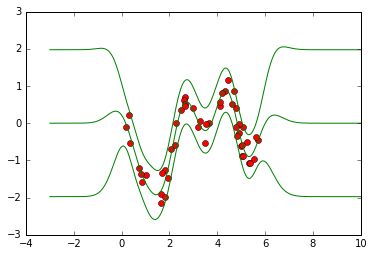

In [4]:
#plot the exact solution and the training data.
figA, axes = plt.subplots(1,1)
axes.plot( xtrain, ytrain, 'ro' )
plotPredictions( axes, exact_model, 'g', None )

In [5]:
#Train VFE model initialized from the perfect solution
VFEmodel, VFEcb = trainSparseModel(xtrain,ytrain,exact_model,False,xtest,ytest)
print "Sparse model parameters for VFE optimization \n"
printModelParameters( VFEmodel )

repeatIndex  0
compiling tensorflow function...
done
optimization terminated, setting model state
repeatIndex  1
optimization terminated, setting model state
repeatIndex  2
optimization terminated, setting model state
repeatIndex  3
optimization terminated, setting model state
repeatIndex  4
optimization terminated, setting model state
repeatIndex  5
optimization terminated, setting model state
repeatIndex  6
optimization terminated, setting model state
repeatIndex  7
optimization terminated, setting model state
repeatIndex  8
optimization terminated, setting model state
repeatIndex  9
optimization terminated, setting model state
repeatIndex  10
optimization terminated, setting model state
repeatIndex  11
optimization terminated, setting model state
repeatIndex  12
optimization terminated, setting model state
repeatIndex  13
optimization terminated, setting model state
repeatIndex  14
optimization terminated, setting model state
repeatIndex  15
optimization terminated, setting model st

In [6]:
#Train FITC model initialized from the perfect solution.
FITCmodel, FITCcb = trainSparseModel(xtrain,ytrain,exact_model,True,xtest,ytest)
print "Sparse model parameters for FITC optimization \n"
printModelParameters( FITCmodel )


repeatIndex  0
compiling tensorflow function...
done
optimization terminated, setting model state
repeatIndex  1
optimization terminated, setting model state
repeatIndex  2
optimization terminated, setting model state
repeatIndex  3
optimization terminated, setting model state
repeatIndex  4
optimization terminated, setting model state
repeatIndex  5
optimization terminated, setting model state
repeatIndex  6
optimization terminated, setting model state
repeatIndex  7
optimization terminated, setting model state
repeatIndex  8
optimization terminated, setting model state
repeatIndex  9
optimization terminated, setting model state
repeatIndex  10
optimization terminated, setting model state
repeatIndex  11
optimization terminated, setting model state
repeatIndex  12
optimization terminated, setting model state
repeatIndex  13
optimization terminated, setting model state
repeatIndex  14
optimization terminated, setting model state
repeatIndex  15
optimization terminated, setting model st

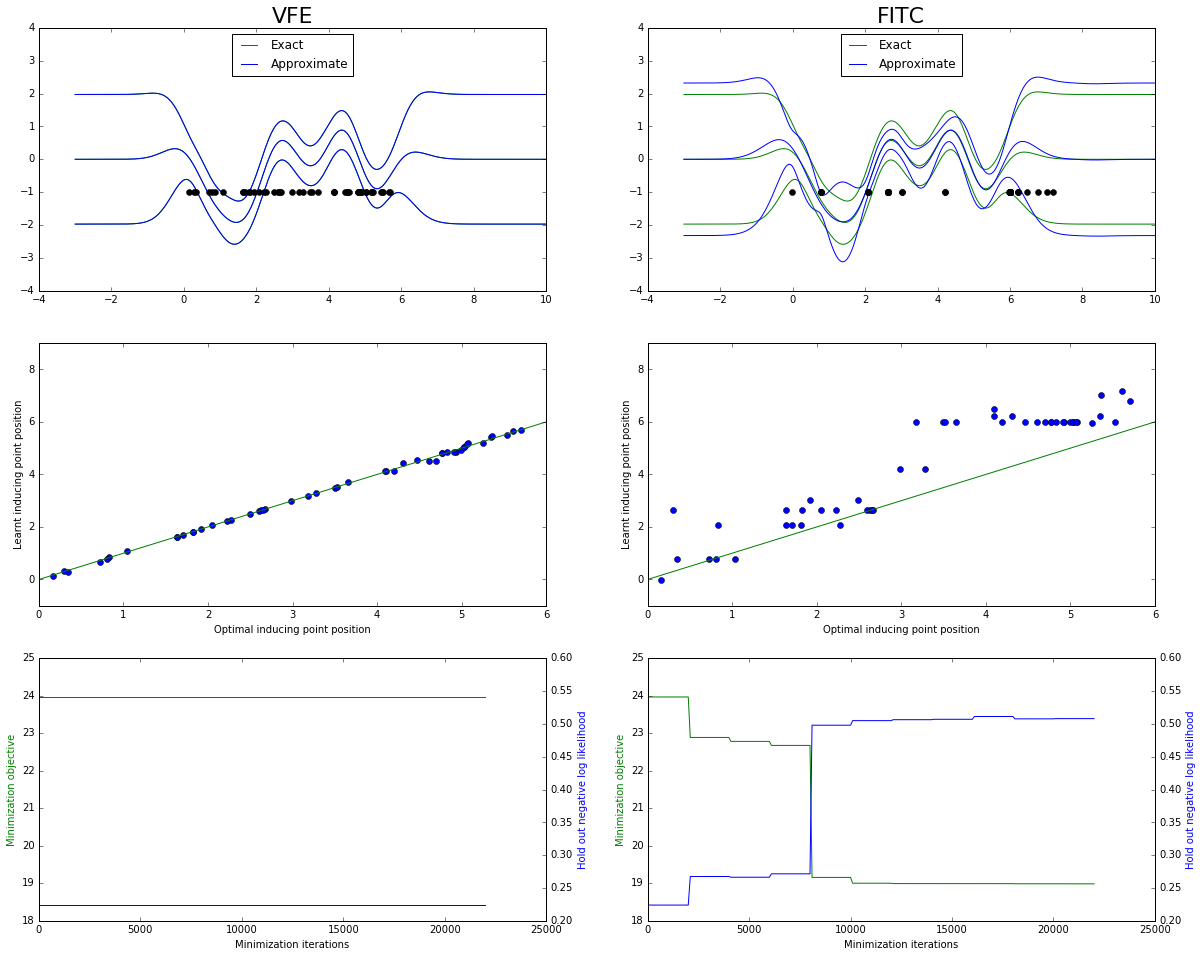

In [9]:
#Plot a comparison of the two algorithms. 
figB, axes = plt.subplots(3,2,figsize=(20, 16))
   
VFEiters = FITCcb.n_iters
VFElog_likelihoods = stretch( len(VFEiters), VFEcb.log_likelihoods )
VFEhold_out_likelihood = stretch(  len(VFEiters), VFEcb.hold_out_likelihood )

plotComparisonFigure( xtrain, VFEmodel, exact_model, axes[0,0], axes[1,0], axes[2,0], VFEiters, VFElog_likelihoods.tolist(), VFEhold_out_likelihood.tolist(), "VFE" )
plotComparisonFigure( xtrain, FITCmodel, exact_model, axes[0,1], axes[1,1], axes[2,1],FITCcb.n_iters, FITCcb.log_likelihoods, FITCcb.hold_out_likelihood , "FITC" )

axes[0,0].set_title('VFE', loc='center', fontdict = {'fontsize': 22} )
axes[0,1].set_title('FITC', loc='center', fontdict = {'fontsize': 22} )  